In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.datasets import get_data

### Using the employee dataset

In [2]:
dataset = get_data("employee", verbose = False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   department             14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


The objective of the dataset is to predict whether an employee left the company or not. We could go a little bit further and instead estimate a <b>probabilty</b> of living the company. 

In [3]:
# preprocessing
X = dataset.iloc[:, :-1]; y = dataset.iloc[:, -1]
X.loc[:, "salary"] = X.loc[:, "salary"].map({"low": 0, "medium": 1, "high": 2})
X = pd.get_dummies(X)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier

X_train, X_test,  y_train, y_test = train_test_split(X.values, y, test_size=.2, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=.2, random_state=42)

estimator = RandomForestClassifier(n_estimators=1000, max_depth=4, random_state=42)
estimator.fit(X_train, y_train)

y_pred = estimator.predict(X_test)
train_pred = estimator.predict(X_train)

print(" Train set : ".center(50, "-"))
print(f"AUC : {roc_auc_score(y_train, train_pred):.2f}\nF1 score : {f1_score(y_train, train_pred):.2f}")
print(" Test set : ".center(50, "-"))
print(f"AUC : {roc_auc_score(y_test, y_pred):.2f}\nF1 score : {f1_score(y_test, y_pred):.2f}")

------------------ Train set : -------------------
AUC : 0.84
F1 score : 0.80
------------------- Test set : -------------------
AUC : 0.83
F1 score : 0.79


Using the classic classification measures, we can say that our RandomForest performs a pretty good classification. But, it does not mean that the estimator is calibrated (i.e performs good probability estimation).

,Brier score,Log loss
No calibration,0.060829,0.233090
Inductive Venn-ABERS,0.036472,0.137323
Cross Venn-ABERS,0.035796,0.135944


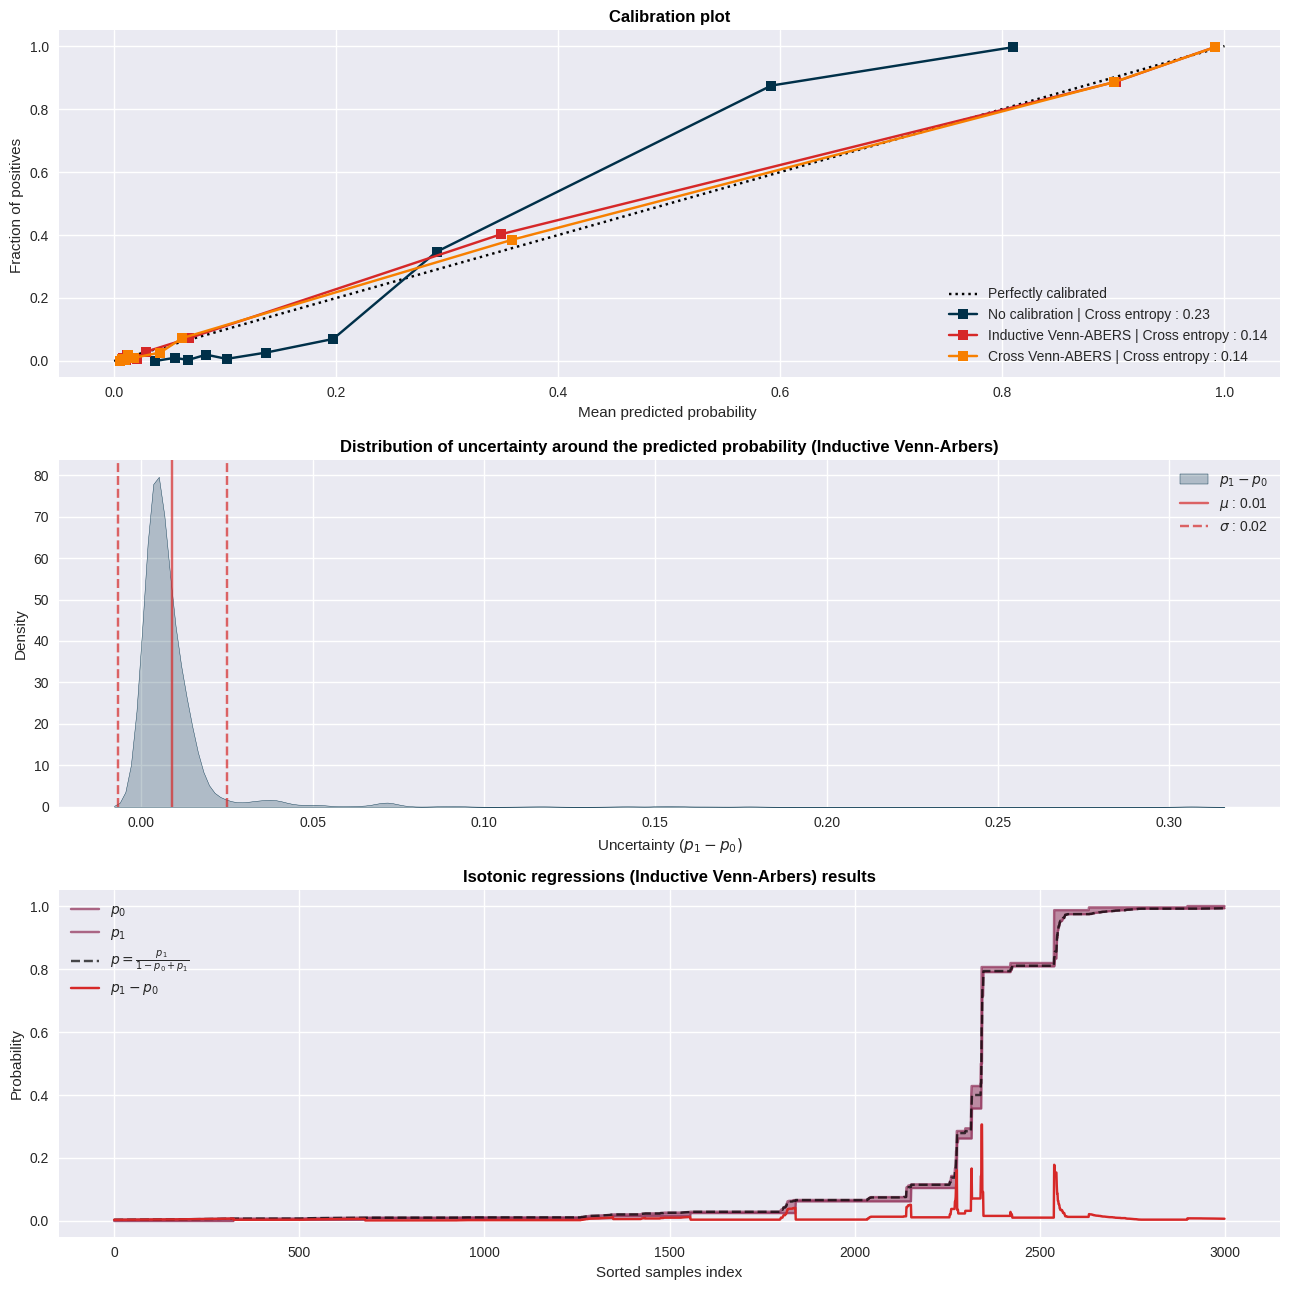

In [5]:
from src.tools import calibration_evaluation

plt.style.use('seaborn')
colors = ["#003049","#d62828", "#f77f00", "#8f2d56"]
calib_score = calibration_evaluation(estimator, X_train, X_calib, X_test, y_train, y_calib.values, y_test, colors = colors, cross_va=True,
                                     save_path="calibration_evaluation.jpeg")
calib_score.style.highlight_min(color = 'chartreuse', axis = 0)

Let's analyse this plot by plot: 
<ul>
<li>The first graph shows that the estimator is not calibrated. It overestimates low probabilities and underestimates high probabilities. In other words, the center of the distribution are too heavy. The results of a transformation called "Venn-ARBERS calibration" (details can be found in the README references) are also shown. In short, Venn-ARBERS performs calibration with interesting theoretical guarantees (unlike Plat scaling or simple isotonic regression). Two modalities of the algorithm are represented on the graph and show similar performances: the inductive and the cross-validate approaches. We can see that with the application of the Venn-ARBERS algorithms, our model becomes well calibrated, and can therefore perform true probability estimation.</li><br>
<li>As previously mentioned, Venn-ARBERS is a model and distribution free calibration algorithm. The algorithm fits two isotonic regressions that give us lower bound (p0) upper bound (p1) of probability. We know that the actual probability lies within the interval p1-p0 and is estimated by the formula below. We can therefore estimate the uncertainty associated with a probability estimate by calculating the p1-p0 distribution. This distribution (on the test set) is shown in the second graph. We can see that most of the density is less than 0.02 and that the mean of the distribution is 0.01. This means that for each probability estimate, we have an uncertainty around the prediction of ~1%. The model is pretty confident on his predictions. As Vovk et al. (2015) say, in practice, the more data points you get, the more confident the model will be.</li><br>
<li>The third graph shows much the same thing as the second, but from a different angle. Here, all test samples are sorted by estimated probability, and the two isotonic regressions (p0 and p1) are plotted. The probability estimated from them using the formula below is plotted with the dotted line. The difference (which measures uncertainty) is also shown. This plot indicates the probability regions where the model becomes more or less confident in its estimation.</li>
</ul>
<br>

Formula for the estimated probabilty based on $p_0$ and $p_1$ : $p = \frac{p_1}{1-p_0-p_1}$

If you want a more quantitative approach to measure calibration, two metrics are commonly used. First, the cross-entropy, also called [Log-Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) measures the difference between the true class and the probability estimate, and passes this difference in a logarithm. Second, the [Brier score](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss) compute the same difference, but instead of the loss use a square instead (getting some kind of root squared error). Log and squares are used to penalize errors exponentially. In both cases, you want to minimize the score ! <br>
In our case, we can see that the scores gets dramatically reduced with the use of Venn-Arbers calibration.

The results are quite clear: without calibration, our model is a good classifier, but it's not calibrated. With calibration, our classifier can also confidently predict accurate probabilities ! That's great :).

### Using the juice dataset

In [6]:
dataset = get_data("juice", verbose=False)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              1070 non-null   int64  
 1   Purchase        1070 non-null   object 
 2   WeekofPurchase  1070 non-null   int64  
 3   StoreID         1070 non-null   int64  
 4   PriceCH         1070 non-null   float64
 5   PriceMM         1070 non-null   float64
 6   DiscCH          1070 non-null   float64
 7   DiscMM          1070 non-null   float64
 8   SpecialCH       1070 non-null   int64  
 9   SpecialMM       1070 non-null   int64  
 10  LoyalCH         1070 non-null   float64
 11  SalePriceMM     1070 non-null   float64
 12  SalePriceCH     1070 non-null   float64
 13  PriceDiff       1070 non-null   float64
 14  Store7          1070 non-null   object 
 15  PctDiscMM       1070 non-null   float64
 16  PctDiscCH       1070 non-null   float64
 17  ListPriceDiff   1070 non-null   f

We can see there that we have less observations than before (~1000 vs ~15000). Uncertainty should then increase.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test,  y_train, y_test = train_test_split(X.values, y, test_size=.2, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=.2, random_state=42)

estimator = KNeighborsClassifier(n_neighbors=10)
estimator.fit(X_train, y_train)

y_pred = estimator.predict(X_test)
train_pred = estimator.predict(X_train)

print(" Train set : ".center(50, "-"))
print(f"AUC : {roc_auc_score(y_train, train_pred):.2f}\nF1 score : {f1_score(y_train, train_pred):.2f}")
print(" Test set : ".center(50, "-"))
print(f"AUC : {roc_auc_score(y_test, y_pred):.2f}\nF1 score : {f1_score(y_test, y_pred):.2f}")

------------------ Train set : -------------------
AUC : 0.94
F1 score : 0.90
------------------- Test set : -------------------
AUC : 0.92
F1 score : 0.87


Once again, we get a pretty good classifier (with a very simple estimator).

Once again, we see that our estimator is not suitable for estimating probabilities, as it always overestimates the true probability. Venn-Arbers does much better. Note also that the second and third graphs show us that, due to the choice of estimator and the number of data points, the model is much less confident in its predictions than the first example. Using other methods, such as Naive Bayes or Logistic Regression, would give us better calibration results, but poorer classification performance. Download the repo and try it out for yourself if you're curious ;).

We've seen a method called Venn-ARBERS calibration to transform the output of your classifier into real probabilities! If you liked it, check out the article, the repositories and the notebook in the readme and don't forget to leave them a star! :).